# Task 1 数据获取与探索分析

In [29]:
# 读取订单数据，并进行探索
# coding: unicode_escope
import pandas as pd
detail=pd.read_csv('C:\\Users\\88\\Desktop\\meal_order_detail.csv')
info=pd.read_csv('C:\\Users\\88\\Desktop\\meal_order_info.csv',encoding='gbk')

In [30]:
# 去除数据中的 \t\r\n
detail['dishes_name']=detail['dishes_name'].map(str.strip)

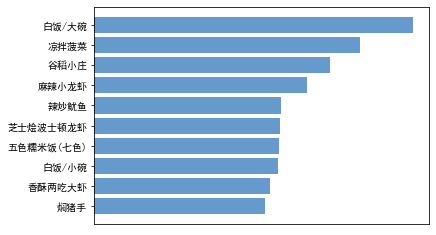

In [31]:
# 绘制热销菜品Top10
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.sans-serif']=['SimHei'] #指定默认字体 SimHei为黑体
mpl.rcParams['axes.unicode_minus']=False #用来正常显示负号

name=['白饭/大碗','凉拌菠菜','谷稻小庄','麻辣小龙虾','辣炒鱿鱼','芝士烩波士顿龙虾','五色糯米饭(七色)','白饭/小碗','香酥两吃大虾','焖猪手']
data=[323,269,239,216,189,188,187,186,178,173]
name.reverse()
data.reverse()
#绘图。
fig, ax = plt.subplots()
b = ax.barh(range(len(name)), data, color='#6699CC')

#设置Y轴纵坐标上的刻度线标签。
ax.set_yticks(range(len(name)))
ax.set_yticklabels(name)
#不要X横坐标上的label标签。
plt.xticks(())
plt.show()

# Task2 数据预处理

In [32]:
# order_status中0，1，2的数据占比
info['order_status'].value_counts()

1    933
0      9
2      3
Name: order_status, dtype: int64

In [33]:
# 删除无效数据
Info=info[~info['order_status'].isin([0,2])]

In [34]:
# 删除订单详情表里有，但在订单表中没有出现的订单
df1=pd.DataFrame(Info,columns=["info_id"])
df2=pd.DataFrame(detail,columns=["order_id","dishes_name","emp_id"])
data=df2[df2['order_id'].isin(df1['info_id'])]

In [35]:
# 删除订单详情表里有，但在订单表中没有出现的订单
drop1=data['dishes_name']=='白饭/小碗'
drop2=data['dishes_name']=='白饭/大碗'
drop=drop1+drop2
Data=data.drop(data.index[drop])

D:\Anaconda\lib\site-packages\pandas\core\computation\expressions.py:180: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


# Task3 构建模型准备

In [36]:
# 只保留点了3个菜及以上的客户数据
a=Data.groupby(by=['order_id'])['order_id'].count()
b=a.loc[a<3]
'''
将点餐数少于3的订单编号结果保存到lessthan3.csv
order_id
199     2
271     2
344     2
480     2
493     2
703     2
1035    2
1054    2
1064    1
1161    2
Name: order_id, dtype: int64
'''
less=pd.read_csv('C:\\Users\\88\\Desktop\\lessthan3.csv')
D=Data[~Data['order_id'].isin(less['order_id'])]

In [42]:
# 将数据按照8:2划分为训练集和测试集
from pandas import DataFrame,Series
import numpy as np 

DD=pd.DataFrame(D,columns=['dishes_name','emp_id'])
dishes_name=DD['dishes_name']
emp_id = DD['emp_id']

test_emp_id = []
train_emp_id = []
np.random.seed(6) 
for i in emp_id:
    if np.random.randint(0,10)<3:
        test_emp_id.append(i)
    else:
        train_emp_id.append(i)

test_data = DD
train_data = DD
for i in test_emp_id:
    train_data = train_data.drop(index=(train_data.loc[(train_data['emp_id']==i)].index))
for i in train_emp_id:
    test_data = test_data.drop(index=(test_data.loc[(test_data['emp_id']==i)].index))

In [52]:
# 构建训练集数据客户-菜品二元矩阵
m = range(len(dishes_name))
n = range(len(train_emp_id))
train_matrix = np.mat(np.zeros((len(dishes_name),len(train_emp_id)))) 
for i in m:
    for j in n:
        if train_data[(train_data.loc[:,'dishes_name']==dishes_name[i]) & (train_data.loc[:,'emp_id']==train_emp_id[j])].empty==False:
            train_matrix[i,j]=1
print(train_matrix)

KeyError: 4

# Task4 模型构建

In [53]:
# 计算菜品与菜品之间的相似度,Jaccard相似度
similar_matrix = np.mat(np.zeros((len(dishes_name),len(dishes_name)))) 
for i in m:
    for h in m:
        cross = 0;union = 0
        for j in n:
            if train_matrix[i,j]==1 and train_matrix[h,j]==1:
                cross=cross+1
            if train_matrix[i,j]==1 or train_matrix[h,j]==1:
                union=union+1
        similar_matrix[i,h]=cross/union
print(similar_matrix)

ZeroDivisionError: division by zero

In [ ]:
# 根据菜品的相似度和客户的历史行为给客户生成推荐表
test_emp_interest_matrix = np.mat(np.zeros((len(test_emp_id),len(dishes_name)))) 
for j in range(len(test_emp_id)):
    test_emp_dishdata = test_data[(test_data.loc[:, 'emp_id'] == test_emp_id[j])] 
    test_emp_dishdata = list(test_emp_dishdata['dishes_name'])
    for i in m:
        interest_score = 0
        for h in test_emp_dishdata:
            index = dishes_name.index(h)
            interest_score = interest_score + 1*similar_matrix[i,index]
        test_emp_interest_matrix[j,i] = interest_score
print(test_emp_interest_matrix)

# Task5 模型评估

In [ ]:
# 构建测试集客户IP-菜品字典
test_emp_data = {}
for j in range(len(test_emp_id)):
    test_emp_dishdata = test_data[(test_data.loc[:, 'emp_id'] == test_emp_id[j])] 
    test_emp_dishdata = list(test_emp_dishdata['dishes_name'])
    test_emp_data[test_emp_id[j]] = test_emp_dishdata
print(test_emp_data)

In [ ]:
# 构建评价指标，并分析推荐效果
test_emp_accuracy = {} 
for j in range(len(test_emp_id)):
    interest_len = len(test_emp_data[test_emp_id[j]])
    true_len = 0
    a = test_emp_interest_matrix[j,:].tolist()[0] 
    b = sorted(a,reverse=True)
    for i in b[0:interest_len]: 
        if dish_name[a.index(i)] in test_emp_data[test_emp_id[j]]:
            true_len = true_len + 1 
    test_emp_accuracy[test_emp_id[j]] = true_len/interest_len
print('字典',test_emp_accuracy)
all_accuracy = 0 
for j in range(len(test_emp_id)):
    all_accuracy = all_accuracy + test_emp_accuracy[test_emp_id[j]]
all_accuracy = all_accuracy/len(test_emp_id)
print(,all_accuracy)